### Rodolfo Augusto da SIlva Arruda - 6381848

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Librariesauxiliares
import numpy as np
import matplotlib.pyplot as plt
import cv2   
from IPython.display import Image
tf.__version__

'2.3.0'

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 0

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

from keras import backend as K

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

Using TensorFlow backend.


### Import images

#### O conjunto de dados utilizado neste projeto foi: "Query-Based Image Dataset for Emotion Recognition (QIDER)" [1]. O objetivo é classificar as imagens segundo 7 classes referentes às emoções: felicidade, raiva, nojo, medo, tristeza, surpresa e neutro.

#### As imagens estão em escala de cinza em formato de quadrados, porém com dimensões diversas. Segundo referência do github dos autores, a dimensão utilizada em sua publicação foi de 150 x 150. Desta forma, mantivemos esse padrão. 

#### As imagens foram normalizadas para escala 1/255

In [3]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
'/home/jovyan/QIDER/train/',
color_mode="grayscale",
class_mode="categorical",
target_size=(150, 150),
batch_size=20,
seed=42)
 

validation_generator = test_datagen.flow_from_directory(
'/home/jovyan/QIDER/val/',
color_mode="grayscale",
class_mode="categorical",
target_size=(150, 150),
batch_size=20,
seed=42)


Found 2910 images belonging to 7 classes.
Found 1000 images belonging to 7 classes.


#### Conferência do número de classes

In [4]:
train_generator.num_classes

7

### Definição do modelo

#### O modelo proposto possui 3 camadas de convolução. 
#### A primeira com dimensões 3x3x32, com função de ativação RELU. Ela recebe como entrada as imagens no formato 150x150.
#### Após a promeira essa camada de convolução é aplicada uma camada de maxpooling 2x2. 
#### Em seguida é aplicada uma camada de dropout, com p=0.5.

#### Novamente é aplicada uma camada convolucional, agora com dimesão 2x2x64 e função de ativação RELU.
#### Na sequência o maxpooling 2x2 e dropout com p=0.7

#### Logo depois, a camada convolucional com dimensão 2x2x128 e ativação RELU, seguida por maxpooling 2x2.

#### É aplicada uma camada de achatamento (FLATTEN), para transformar o tensor 3D em um vetor 2D
#### É aplicada uma camada totalmente conectada com 32 neurônios e função de ativação RELU 

#### Por fim, entra a camda de softmax com 7 classes


In [15]:
model = keras.models.Sequential()

model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.5,seed=42))

model.add(keras.layers.Conv2D(64, (2, 2), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Dropout(0.7,seed=42))

model.add(keras.layers.Conv2D(128, (2, 2), activation='relu'))
model.add(keras.layers.MaxPooling2D((2, 2)))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))

model.add(keras.layers.Dense(7, activation='softmax'))


#### A função de perda escolhda foi a categorical_crossentropy. A métrica de otimização escolhida foi a Acurácia e o otimizador foi o ADAM

In [16]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

#### A rede proposta possui 1.225.479 parâmetros

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 73, 73, 64)        8256      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 35, 35, 128)       3

#### Primeiro treinamento: Avaliar a relação de acurácia no conjunto de treino e teste:

In [8]:
history = model.fit(
train_generator,
steps_per_epoch=100,
epochs=100,
validation_data=validation_generator,
validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 75s 750ms/step - loss: 2.1245 - accuracy: 0.2407 - val_loss: 1.8818 - val_accuracy: 0.4650
Epoch 2/100
100/100 [==============================] - 71s 710ms/step - loss: 1.8665 - accuracy: 0.2588 - val_loss: 1.8492 - val_accuracy: 0.4650
Epoch 3/100
100/100 [==============================] - 70s 699ms/step - loss: 1.8480 - accuracy: 0.2573 - val_loss: 1.8816 - val_accuracy: 0.1430
Epoch 4/100
100/100 [==============================] - 71s 709ms/step - loss: 1.8278 - accuracy: 0.2779 - val_loss: 1.8285 - val_accuracy: 0.3530
Epoch 5/100
100/100 [==============================] - 69s 694ms/step - loss: 1.7820 - accuracy: 0.3030 - val_loss: 1.7805 - val_accuracy: 0.4710
Epoch 6/100
100/100 [==============================] - 69s 694ms/step - loss: 1.7065 - accuracy: 0.3357 - val_loss: 1.7646 - val_accuracy: 0.4530
Epoch 7/100
100/100 [==============================] - 69s 688ms/step - loss: 1.6625 - accuracy: 0.3578 - val_loss: 1.6294 -

Epoch 57/100
100/100 [==============================] - 68s 680ms/step - loss: 0.3685 - accuracy: 0.8834 - val_loss: 1.8034 - val_accuracy: 0.5250
Epoch 58/100
100/100 [==============================] - 69s 690ms/step - loss: 0.3679 - accuracy: 0.8819 - val_loss: 1.8259 - val_accuracy: 0.5420
Epoch 59/100
100/100 [==============================] - 69s 687ms/step - loss: 0.3240 - accuracy: 0.8985 - val_loss: 1.7869 - val_accuracy: 0.5440
Epoch 60/100
100/100 [==============================] - 69s 687ms/step - loss: 0.3155 - accuracy: 0.8985 - val_loss: 1.8438 - val_accuracy: 0.5300
Epoch 61/100
100/100 [==============================] - 70s 696ms/step - loss: 0.3113 - accuracy: 0.8945 - val_loss: 2.0814 - val_accuracy: 0.4580
Epoch 62/100
100/100 [==============================] - 69s 688ms/step - loss: 0.3124 - accuracy: 0.9060 - val_loss: 1.7817 - val_accuracy: 0.5290
Epoch 63/100
100/100 [==============================] - 69s 693ms/step - loss: 0.3301 - accuracy: 0.8930 - val_loss: 1

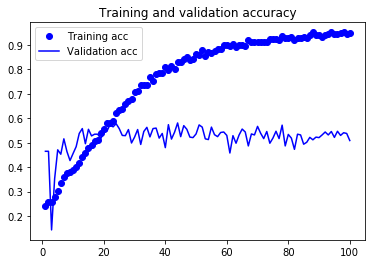

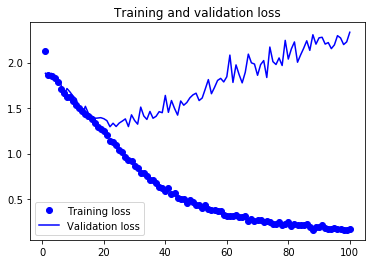

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

#### Comentário: A acurácia no conjunto de teste cresceu até o nível de mais de 95% no conjunto de teste. No entanto, essa acurácia não foi acompanha pela avaliação no conjunto de teste. Isso indica que o modelo está sofrendo com superajuste!

### Ajuste do mesmo modelo, com menos ciclos (early stopping)

#### Número de ciclos: 20

In [17]:
history = model.fit(
train_generator,
steps_per_epoch=100,
epochs=20,
validation_data=validation_generator,
validation_steps=50
)

Epoch 1/20
100/100 [==============================] - 69s 691ms/step - loss: 2.0603 - accuracy: 0.1704 - val_loss: 1.9213 - val_accuracy: 0.4650
Epoch 2/20
100/100 [==============================] - 69s 691ms/step - loss: 1.8590 - accuracy: 0.2205 - val_loss: 1.8975 - val_accuracy: 0.4650
Epoch 3/20
100/100 [==============================] - 69s 689ms/step - loss: 1.8534 - accuracy: 0.2487 - val_loss: 1.8928 - val_accuracy: 0.4650
Epoch 4/20
100/100 [==============================] - 69s 685ms/step - loss: 1.8382 - accuracy: 0.2600 - val_loss: 1.8803 - val_accuracy: 0.4650
Epoch 5/20
100/100 [==============================] - 68s 683ms/step - loss: 1.7905 - accuracy: 0.2513 - val_loss: 1.8276 - val_accuracy: 0.4650
Epoch 6/20
100/100 [==============================] - 69s 692ms/step - loss: 1.7482 - accuracy: 0.2518 - val_loss: 1.8122 - val_accuracy: 0.4650
Epoch 7/20
100/100 [==============================] - 69s 690ms/step - loss: 1.7064 - accuracy: 0.2765 - val_loss: 1.6607 - val_ac

#### Uma característica interessante do framework Keras é que ele permite continuar o treinamento do ponto em que parou em um trinamento prévio. Dessa forma, foi realizado alguns ciclos adicionais para  ajuste fino. Mais 5 ciclos.

In [18]:
history = model.fit(
train_generator,
steps_per_epoch=100,
epochs=5,
validation_data=validation_generator,
validation_steps=50
)

Epoch 1/5
100/100 [==============================] - 70s 695ms/step - loss: 1.4624 - accuracy: 0.4130 - val_loss: 1.6013 - val_accuracy: 0.4510
Epoch 2/5
100/100 [==============================] - 69s 686ms/step - loss: 1.4393 - accuracy: 0.4276 - val_loss: 1.4431 - val_accuracy: 0.5240
Epoch 3/5
100/100 [==============================] - 69s 689ms/step - loss: 1.4196 - accuracy: 0.4265 - val_loss: 1.5038 - val_accuracy: 0.5000
Epoch 4/5
100/100 [==============================] - 69s 692ms/step - loss: 1.3813 - accuracy: 0.4427 - val_loss: 1.3934 - val_accuracy: 0.5490
Epoch 5/5
100/100 [==============================] - 69s 693ms/step - loss: 1.3852 - accuracy: 0.4380 - val_loss: 1.5185 - val_accuracy: 0.5030


#### Mais 5 ciclos

In [19]:
history = model.fit(
train_generator,
steps_per_epoch=100,
epochs=5,
validation_data=validation_generator,
validation_steps=50
)

Epoch 1/5
100/100 [==============================] - 69s 694ms/step - loss: 1.3421 - accuracy: 0.4500 - val_loss: 1.4492 - val_accuracy: 0.5390
Epoch 2/5
100/100 [==============================] - 69s 691ms/step - loss: 1.3329 - accuracy: 0.4885 - val_loss: 1.3648 - val_accuracy: 0.5600
Epoch 3/5
100/100 [==============================] - 69s 688ms/step - loss: 1.2650 - accuracy: 0.4950 - val_loss: 1.3941 - val_accuracy: 0.5410
Epoch 4/5
100/100 [==============================] - 68s 681ms/step - loss: 1.2166 - accuracy: 0.5211 - val_loss: 1.3329 - val_accuracy: 0.5500
Epoch 5/5
100/100 [==============================] - 69s 686ms/step - loss: 1.1862 - accuracy: 0.5450 - val_loss: 1.3696 - val_accuracy: 0.5670


### OK! Treinamento finalizado! Acurácia de 54.5% no treino e 56.7% do teste.

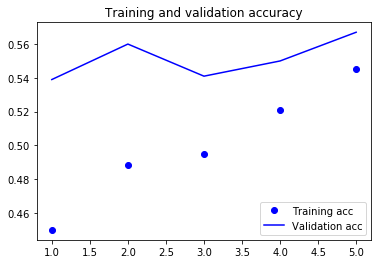

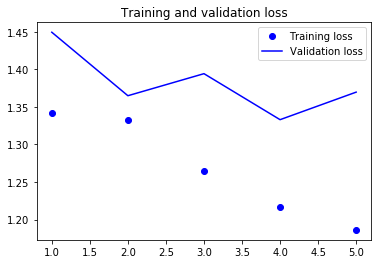

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Salvar modelo

In [25]:
model.save('faces_1')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: faces_1/assets


### Load model

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Librariesauxiliares
import numpy as np
import matplotlib.pyplot as plt
import cv2   
from IPython.display import Image
tf.__version__

'2.3.0'

In [2]:
model= keras.models.load_model("faces_1")

In [3]:
model

### Predictições sobre imagens da internet

In [4]:
def f_prediction(img):
    predictions_single = model.predict(img)
    
    if np.argmax(predictions_single) == 0:
        print('raiva')
    elif np.argmax(predictions_single) == 1:
        print('nojo')
    elif np.argmax(predictions_single) == 2:
        print('medo')
    elif np.argmax(predictions_single) == 3:
        print('felicidade')
    elif np.argmax(predictions_single) == 4:
        print('neutra')
    elif np.argmax(predictions_single) == 5:
        print('tristeza')
    elif np.argmax(predictions_single) == 6:
        print('surpresa')

## Raiva:

In [5]:
img_name = './expressoes_internet/raiva.png'
img = cv2.imread(img_name,0)
img.shape

(165, 175)

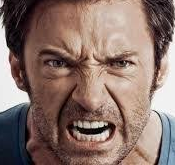

In [6]:
from IPython.display import Image
Image(filename='./expressoes_internet/raiva.png') 


In [7]:
img = np.reshape(cv2.imread(img_name,0),(img.shape[0], img.shape[1], 1))
print(img.shape)

(165, 175, 1)


In [8]:
img =  cv2.resize(img,(150,150))
img = np.reshape(img,(150,150, 1))
print(img.shape)

(150, 150, 1)


In [9]:
img = (np.expand_dims(img,0))

In [10]:
print(img.shape)

(1, 150, 150, 1)


### Predição

In [11]:
f_prediction(img)

raiva


## Nojo:

In [12]:
img_name = './expressoes_internet/nojo.png'
img = cv2.imread(img_name,0)
img.shape


(198, 138)

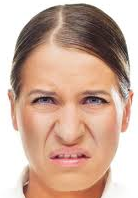

In [13]:
from IPython.display import Image
Image(filename='./expressoes_internet/nojo.png') 


In [14]:
img = np.reshape(cv2.imread(img_name,0),(img.shape[0], img.shape[1], 1))
print(img.shape)

(198, 138, 1)


In [15]:
img =  cv2.resize(img,(150,150))
img = np.reshape(img,(150,150, 1))
print(img.shape)

(150, 150, 1)


In [16]:
img = (np.expand_dims(img,0))

In [17]:
print(img.shape)

(1, 150, 150, 1)


### Predição

In [18]:
f_prediction(img)

surpresa


## Medo:

In [19]:
img_name = './expressoes_internet/medo.png'
img = cv2.imread(img_name,0)
img.shape


(254, 198)

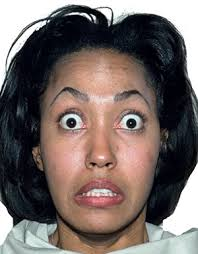

In [20]:
from IPython.display import Image
Image(filename='./expressoes_internet/medo.png') 


In [21]:
img = np.reshape(cv2.imread(img_name,0),(img.shape[0], img.shape[1], 1))
print(img.shape)

(254, 198, 1)


In [22]:
img =  cv2.resize(img,(150,150))
img = np.reshape(img,(150,150, 1))
print(img.shape)

(150, 150, 1)


In [23]:
img = (np.expand_dims(img,0))

In [24]:
print(img.shape)

(1, 150, 150, 1)


### Predição

In [25]:
f_prediction(img)

surpresa


## Felicidade:

In [26]:
img_name = './expressoes_internet/felicidade.png'
img = cv2.imread(img_name,0)
img.shape


(164, 205)

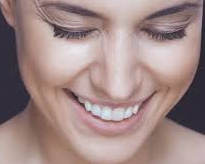

In [27]:
from IPython.display import Image
Image(filename='./expressoes_internet/felicidade.png') 


In [28]:
img = np.reshape(cv2.imread(img_name,0),(img.shape[0], img.shape[1], 1))
print(img.shape)

(164, 205, 1)


In [29]:
img =  cv2.resize(img,(150,150))
img = np.reshape(img,(150,150, 1))
print(img.shape)

(150, 150, 1)


In [30]:
img = (np.expand_dims(img,0))

In [31]:
print(img.shape)

(1, 150, 150, 1)


### Predição

In [32]:
f_prediction(img)

surpresa


## Neutra:

In [33]:
img_name = './expressoes_internet/neutro.png'
img = cv2.imread(img_name,0)
img.shape

(134, 110)

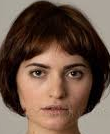

In [34]:
from IPython.display import Image
Image(filename='./expressoes_internet/neutro.png') 

In [35]:
img = np.reshape(cv2.imread(img_name,0),(img.shape[0], img.shape[1], 1))
print(img.shape)

(134, 110, 1)


In [36]:
img =  cv2.resize(img,(150,150))
img = np.reshape(img,(150,150, 1))
print(img.shape)

(150, 150, 1)


In [37]:
img = (np.expand_dims(img,0))

In [38]:
print(img.shape)

(1, 150, 150, 1)


### Predição

In [39]:
f_prediction(img)

felicidade


## Tristeza:

In [40]:
img_name = './expressoes_internet/triteza.png'
img = cv2.imread(img_name,0)
img.shape


(184, 184)

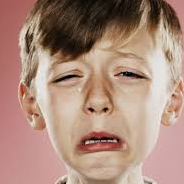

In [41]:
from IPython.display import Image
Image(filename='./expressoes_internet/triteza.png') 

In [42]:
img = np.reshape(cv2.imread(img_name,0),(img.shape[0], img.shape[1], 1))
print(img.shape)

(184, 184, 1)


In [43]:
img =  cv2.resize(img,(150,150))
img = np.reshape(img,(150,150, 1))
print(img.shape)

(150, 150, 1)


In [44]:
img = (np.expand_dims(img,0))

In [45]:
print(img.shape)

(1, 150, 150, 1)


In [46]:
f_prediction(img)

felicidade


## Surpresa:

In [47]:
img_name = './expressoes_internet/surpresa.png'
img = cv2.imread(img_name,0)
img.shape


(127, 94)

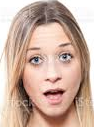

In [48]:
from IPython.display import Image
Image(filename='./expressoes_internet/surpresa.png')

In [49]:
img = np.reshape(cv2.imread(img_name,0),(img.shape[0], img.shape[1], 1))

print(img.shape)

(127, 94, 1)


In [50]:
img =  cv2.resize(img,(150,150))
img = np.reshape(img,(150,150, 1))
print(img.shape)

(150, 150, 1)


In [51]:
img = (np.expand_dims(img,0))

In [52]:
print(img.shape)

(1, 150, 150, 1)


### Predição

In [53]:
f_prediction(img)

felicidade


### Conclusão: Modelo acertou 1 em 7 imagens coletadas da internet. Acurácia muito baixa! Novas abordagens são necessárias para aumentar a capacidade do modelo!

### Referências

#### [1] D. C. Tozadore, C. M. Ranieri, G. V. Nardari, R. A. F. Romero and V. C. Guizilini, "Effects of Emotion Grouping for Recognition in Human-Robot Interactions," 2018 7th Brazilian Conference on Intelligent Systems (BRACIS), Sao Paulo, 2018, pp. 438-443, doi: 10.1109/BRACIS.2018.00082.